In [6]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
import baseline_classification as bc
from classification import *
from xgboost_classifier import *
from testaccuracy import *

In [39]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName=['docEmbeddings_win2_load_all.d2v', 
           'textModel_win=2_no_outside', 
           'docEmbeddings_30_load_all.d2v', 
           'textModel_win=30_no_outside']

In [40]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)

In [41]:
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
y = np.array(bc.getLabels(encoded_y))

In [42]:
print(encoded_y.shape)
print(train_y[0:9])
print(y.shape)
print(encoded_y[[1,3,5]])

(3689, 9)
[1 2 2 3 4 4 5 1 4]
(3689,)
[[0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]]


In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import numpy as np
import util
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
def nn_cross_validation(X, y, encoded_y, skf = StratifiedKFold(n_splits=10, random_state = 66, shuffle = True)):
    ret = []
    mat = 0
    LOSS = []
    ACC = []
    NMI = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = encoded_y[train_index], encoded_y[test_index]
        model = nn_baseline_model(25, 25, 200)
        model = train_nn_model_simple(model, X_train, y_train, 'temp.h5')

        y_pred_proba = model.predict_proba(X_test)
        y_pred = np.argmax(y_pred_proba, axis = 1)
        y_pred = np.array(y_pred)

        acc = accuracy_score(y[test_index], y_pred)
        nmi = normalized_mutual_info_score(y_pred, y[test_index])
        loss = log_loss(y[test_index], y_pred_proba)
        ACC.append(acc)
        LOSS.append(loss)
        NMI.append(nmi)
        cnf_matrix = confusion_matrix(y[test_index], y_pred)
        mat = mat + cnf_matrix
    print("Accuracy: %.4f ± %.4f" % (np.mean(ACC), np.std(ACC)))
    print("NMI: %.4f ± %.4f" % (np.mean(NMI), np.std(NMI)))
    print("Log_loss: %.4f ± %.4f" % (np.mean(LOSS), np.std(LOSS)))
    mat = mat / skf.get_n_splits()
    mat = np.array(mat)
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    util.plot_confusion_matrix(mat, classes='', normalize=True,
                      title='Confusion matrix')
    return mat

In [67]:
def train_nn_model_simple(model, train_set, encoded_y, filename = 'best_weight_predict_all.h5'):
    print('begin training\n')
    best_acc = 0
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for i in range(30):
        estimator=model.fit(train_set, encoded_y, validation_split=0.01, epochs=2, batch_size=64)
        if (best_acc < estimator.history['val_acc'][-1] * 100):
            best_acc = estimator.history['val_acc'][-1] * 100
            model.save_weights(filename)
    return model

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_win2_load_all.d2v
Use test model: docEmbeddings_win2_load_all.d2v
begin training



/Users/qqu0127/Desktop/CS249/master/Personalized-Medicine-Redefining-Cancer-Treatment/src/classification.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=250, activation="relu", kernel_initializer="normal")`
  model.add(Dense(256, input_dim=Text_INPUT_DIM+ Gene_INPUT_DIM + Variation_INPUT_DIM, init='normal', activation='relu'))
/Users/qqu0127/Desktop/CS249/master/Personalized-Medicine-Redefining-Cancer-Treatment/src/classification.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  model.add(Dense(256, init='normal', activation='relu'))
/Users/qqu0127/Desktop/CS249/master/Personalized-Medicine-Redefining-Cancer-Treatment/src/classification.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  model.add(Dense(80, init='normal', activation='relu'))
/Users/qqu0127/Desktop/CS249/master/Personalized-Medicin

Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 1s 285us/step - loss: 1.9869 - acc: 0.2575 - val_loss: 1.5532 - val_acc: 0.4706
Epoch 2/2
3281/3281 [==============================] - 0s 60us/step - loss: 1.6185 - acc: 0.4224 - val_loss: 1.2641 - val_acc: 0.6471
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 60us/step - loss: 1.4198 - acc: 0.4706 - val_loss: 1.0899 - val_acc: 0.5882
Epoch 2/2
3281/3281 [==============================] - 0s 64us/step - loss: 1.3238 - acc: 0.5084 - val_loss: 0.9800 - val_acc: 0.7059
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 60us/step - loss: 1.2537 - acc: 0.5468 - val_loss: 0.9253 - val_acc: 0.6471
Epoch 2/2
3281/3281 [==============================] - 0s 61us/step - loss: 1.1905 - acc: 0.5544 - val_loss: 0.8993 - val_acc: 0.6765
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3

3281/3281 [==============================] - 0s 62us/step - loss: 0.6341 - acc: 0.7546 - val_loss: 0.7874 - val_acc: 0.6765
Epoch 2/2
3281/3281 [==============================] - 0s 61us/step - loss: 0.6328 - acc: 0.7528 - val_loss: 0.7930 - val_acc: 0.6765
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 61us/step - loss: 0.6238 - acc: 0.7607 - val_loss: 0.7893 - val_acc: 0.6471
Epoch 2/2
3281/3281 [==============================] - 0s 60us/step - loss: 0.6147 - acc: 0.7610 - val_loss: 0.7951 - val_acc: 0.6471
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 61us/step - loss: 0.6075 - acc: 0.7638 - val_loss: 0.8211 - val_acc: 0.6471
Epoch 2/2
3281/3281 [==============================] - 0s 62us/step - loss: 0.6185 - acc: 0.7577 - val_loss: 0.7955 - val_acc: 0.6471
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 61us/step 

3283/3283 [==============================] - 0s 64us/step - loss: 0.6543 - acc: 0.7518 - val_loss: 0.8405 - val_acc: 0.5882
Epoch 2/2
3283/3283 [==============================] - 0s 62us/step - loss: 0.6717 - acc: 0.7496 - val_loss: 0.7723 - val_acc: 0.6471
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 72us/step - loss: 0.6665 - acc: 0.7481 - val_loss: 0.8169 - val_acc: 0.6176
Epoch 2/2
3283/3283 [==============================] - 0s 62us/step - loss: 0.6462 - acc: 0.7511 - val_loss: 0.8067 - val_acc: 0.6471
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 62us/step - loss: 0.6429 - acc: 0.7493 - val_loss: 0.7978 - val_acc: 0.6471
Epoch 2/2
3283/3283 [==============================] - 0s 69us/step - loss: 0.6363 - acc: 0.7569 - val_loss: 0.8056 - val_acc: 0.6471
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 60us/step 

3284/3284 [==============================] - 0s 70us/step - loss: 0.7322 - acc: 0.7220 - val_loss: 0.8531 - val_acc: 0.5294
Epoch 2/2
3284/3284 [==============================] - 0s 67us/step - loss: 0.7519 - acc: 0.7080 - val_loss: 0.8427 - val_acc: 0.5882
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 66us/step - loss: 0.7412 - acc: 0.7278 - val_loss: 0.8003 - val_acc: 0.6176
Epoch 2/2
3284/3284 [==============================] - 0s 68us/step - loss: 0.7097 - acc: 0.7256 - val_loss: 0.8220 - val_acc: 0.5588
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 69us/step - loss: 0.7180 - acc: 0.7305 - val_loss: 0.8395 - val_acc: 0.5882
Epoch 2/2
3284/3284 [==============================] - 0s 67us/step - loss: 0.6934 - acc: 0.7406 - val_loss: 0.8500 - val_acc: 0.5588
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 66us/step 

3285/3285 [==============================] - 0s 61us/step - loss: 0.8197 - acc: 0.7011 - val_loss: 0.8515 - val_acc: 0.5588
Epoch 2/2
3285/3285 [==============================] - 0s 61us/step - loss: 0.7932 - acc: 0.6983 - val_loss: 0.8676 - val_acc: 0.6176
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 68us/step - loss: 0.7994 - acc: 0.6983 - val_loss: 0.8649 - val_acc: 0.5294
Epoch 2/2
3285/3285 [==============================] - 0s 62us/step - loss: 0.7840 - acc: 0.6989 - val_loss: 0.8556 - val_acc: 0.5882
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 60us/step - loss: 0.7631 - acc: 0.7172 - val_loss: 0.8301 - val_acc: 0.6176
Epoch 2/2
3285/3285 [==============================] - 0s 62us/step - loss: 0.7691 - acc: 0.7111 - val_loss: 0.8335 - val_acc: 0.5882
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 62us/step 

3286/3286 [==============================] - 0s 67us/step - loss: 0.8691 - acc: 0.6716 - val_loss: 0.8114 - val_acc: 0.6176
Epoch 2/2
3286/3286 [==============================] - 0s 68us/step - loss: 0.8534 - acc: 0.6732 - val_loss: 0.8039 - val_acc: 0.6471
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 67us/step - loss: 0.8450 - acc: 0.6823 - val_loss: 0.7932 - val_acc: 0.6176
Epoch 2/2
3286/3286 [==============================] - 0s 66us/step - loss: 0.8248 - acc: 0.6917 - val_loss: 0.7689 - val_acc: 0.6471
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 62us/step - loss: 0.8198 - acc: 0.6911 - val_loss: 0.8278 - val_acc: 0.6176
Epoch 2/2
3286/3286 [==============================] - 0s 64us/step - loss: 0.8088 - acc: 0.6878 - val_loss: 0.8099 - val_acc: 0.6176
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 69us/step 

3286/3286 [==============================] - 0s 63us/step - loss: 1.0112 - acc: 0.6226 - val_loss: 0.8895 - val_acc: 0.6471
Epoch 2/2
3286/3286 [==============================] - 0s 61us/step - loss: 1.0001 - acc: 0.6287 - val_loss: 0.8544 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 63us/step - loss: 0.9729 - acc: 0.6400 - val_loss: 0.8934 - val_acc: 0.7059
Epoch 2/2
3286/3286 [==============================] - 0s 73us/step - loss: 0.9694 - acc: 0.6488 - val_loss: 0.8666 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 62us/step - loss: 0.9464 - acc: 0.6522 - val_loss: 0.8393 - val_acc: 0.6471
Epoch 2/2
3286/3286 [==============================] - 0s 62us/step - loss: 0.9305 - acc: 0.6586 - val_loss: 0.8525 - val_acc: 0.7353
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 64us/step 

3287/3287 [==============================] - 0s 62us/step - loss: 1.2380 - acc: 0.5394 - val_loss: 0.9572 - val_acc: 0.7353
Epoch 2/2
3287/3287 [==============================] - 0s 61us/step - loss: 1.1949 - acc: 0.5513 - val_loss: 0.8722 - val_acc: 0.7647
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 61us/step - loss: 1.1407 - acc: 0.5710 - val_loss: 0.8703 - val_acc: 0.7353
Epoch 2/2
3287/3287 [==============================] - 0s 61us/step - loss: 1.1212 - acc: 0.5844 - val_loss: 0.8077 - val_acc: 0.7647
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 63us/step - loss: 1.1010 - acc: 0.5978 - val_loss: 0.8387 - val_acc: 0.7647
Epoch 2/2
3287/3287 [==============================] - 0s 62us/step - loss: 1.0781 - acc: 0.6066 - val_loss: 0.8205 - val_acc: 0.7647
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 62us/step 

3287/3287 [==============================] - 0s 63us/step - loss: 0.6087 - acc: 0.7591 - val_loss: 0.6834 - val_acc: 0.6471
Epoch 2/2
3287/3287 [==============================] - 0s 63us/step - loss: 0.5994 - acc: 0.7688 - val_loss: 0.6944 - val_acc: 0.6176
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 89us/step - loss: 0.6016 - acc: 0.7630 - val_loss: 0.6467 - val_acc: 0.6176
Epoch 2/2
3287/3287 [==============================] - 0s 64us/step - loss: 0.5969 - acc: 0.7667 - val_loss: 0.6703 - val_acc: 0.6176
begin training

Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 1s 365us/step - loss: 1.9177 - acc: 0.3171 - val_loss: 1.4587 - val_acc: 0.6176
Epoch 2/2
3289/3289 [==============================] - 0s 64us/step - loss: 1.5701 - acc: 0.4354 - val_loss: 1.1344 - val_acc: 0.6176
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================

3289/3289 [==============================] - 0s 72us/step - loss: 0.6498 - acc: 0.7492 - val_loss: 0.8562 - val_acc: 0.5882
Epoch 2/2
3289/3289 [==============================] - 0s 69us/step - loss: 0.6451 - acc: 0.7513 - val_loss: 0.8486 - val_acc: 0.6765
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 68us/step - loss: 0.6480 - acc: 0.7589 - val_loss: 0.8309 - val_acc: 0.6471
Epoch 2/2
3289/3289 [==============================] - 0s 69us/step - loss: 0.6393 - acc: 0.7549 - val_loss: 0.8096 - val_acc: 0.6471
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 69us/step - loss: 0.6419 - acc: 0.7510 - val_loss: 0.8447 - val_acc: 0.6471
Epoch 2/2
3289/3289 [==============================] - 0s 68us/step - loss: 0.6251 - acc: 0.7559 - val_loss: 0.8394 - val_acc: 0.5882
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 97us/step 

3290/3290 [==============================] - 0s 79us/step - loss: 0.7216 - acc: 0.7310 - val_loss: 0.8918 - val_acc: 0.6176
Epoch 2/2
3290/3290 [==============================] - 0s 74us/step - loss: 0.7082 - acc: 0.7401 - val_loss: 0.8755 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 70us/step - loss: 0.7021 - acc: 0.7410 - val_loss: 0.8880 - val_acc: 0.6176
Epoch 2/2
3290/3290 [==============================] - 0s 64us/step - loss: 0.7056 - acc: 0.7404 - val_loss: 0.8674 - val_acc: 0.6176
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 66us/step - loss: 0.7038 - acc: 0.7362 - val_loss: 0.8628 - val_acc: 0.6176
Epoch 2/2
3290/3290 [==============================] - 0s 75us/step - loss: 0.6880 - acc: 0.7416 - val_loss: 0.8751 - val_acc: 0.6176
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 74us/step 

3290/3290 [==============================] - 0s 65us/step - loss: 0.7605 - acc: 0.7185 - val_loss: 0.7825 - val_acc: 0.6765
Epoch 2/2
3290/3290 [==============================] - 0s 63us/step - loss: 0.7397 - acc: 0.7207 - val_loss: 0.7754 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 63us/step - loss: 0.7395 - acc: 0.7316 - val_loss: 0.7772 - val_acc: 0.6471
Epoch 2/2
3290/3290 [==============================] - 0s 68us/step - loss: 0.7172 - acc: 0.7304 - val_loss: 0.7780 - val_acc: 0.6176
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 65us/step - loss: 0.7249 - acc: 0.7243 - val_loss: 0.7678 - val_acc: 0.6471
Epoch 2/2
3290/3290 [==============================] - 0s 98us/step - loss: 0.7210 - acc: 0.7407 - val_loss: 0.7842 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 89us/step 

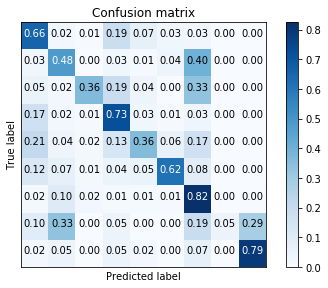

Successfully loaded the textmodel from ../model/doc2vec/textModel_win=2_no_outside
Use test model: textModel_win=2_no_outside
begin training

Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 2s 618us/step - loss: 1.9703 - acc: 0.2703 - val_loss: 1.5696 - val_acc: 0.4118
Epoch 2/2
3281/3281 [==============================] - 0s 71us/step - loss: 1.6059 - acc: 0.4093 - val_loss: 1.3645 - val_acc: 0.6471
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 68us/step - loss: 1.4222 - acc: 0.4675 - val_loss: 1.2299 - val_acc: 0.6471
Epoch 2/2
3281/3281 [==============================] - 0s 71us/step - loss: 1.3299 - acc: 0.5008 - val_loss: 1.1269 - val_acc: 0.6176
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 64us/step - loss: 1.2693 - acc: 0.5230 - val_loss: 1.0226 - val_acc: 0.7353
Epoch 2/2
3281/3281 [============================

3281/3281 [==============================] - 0s 65us/step - loss: 0.6038 - acc: 0.7714 - val_loss: 0.9695 - val_acc: 0.6176
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 69us/step - loss: 0.5939 - acc: 0.7732 - val_loss: 1.0041 - val_acc: 0.6471
Epoch 2/2
3281/3281 [==============================] - 0s 65us/step - loss: 0.5927 - acc: 0.7720 - val_loss: 0.9954 - val_acc: 0.6176
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 65us/step - loss: 0.5863 - acc: 0.7799 - val_loss: 0.9608 - val_acc: 0.6471
Epoch 2/2
3281/3281 [==============================] - 0s 63us/step - loss: 0.5782 - acc: 0.7781 - val_loss: 1.0004 - val_acc: 0.6471
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 79us/step - loss: 0.5658 - acc: 0.7787 - val_loss: 1.0274 - val_acc: 0.6176
Epoch 2/2
3281/3281 [==============================] - 0s 66us/step 

3283/3283 [==============================] - 0s 68us/step - loss: 0.6544 - acc: 0.7609 - val_loss: 0.9156 - val_acc: 0.7059
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 63us/step - loss: 0.6447 - acc: 0.7645 - val_loss: 0.9882 - val_acc: 0.6765
Epoch 2/2
3283/3283 [==============================] - 0s 66us/step - loss: 0.6260 - acc: 0.7688 - val_loss: 0.9464 - val_acc: 0.6765
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 64us/step - loss: 0.6333 - acc: 0.7722 - val_loss: 0.9188 - val_acc: 0.6765
Epoch 2/2
3283/3283 [==============================] - 0s 68us/step - loss: 0.6186 - acc: 0.7737 - val_loss: 0.9544 - val_acc: 0.6765
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 70us/step - loss: 0.6150 - acc: 0.7746 - val_loss: 0.9718 - val_acc: 0.6176
Epoch 2/2
3283/3283 [==============================] - 0s 64us/step 

3284/3284 [==============================] - 0s 63us/step - loss: 0.7113 - acc: 0.7421 - val_loss: 0.9881 - val_acc: 0.6765
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 63us/step - loss: 0.7072 - acc: 0.7427 - val_loss: 0.9748 - val_acc: 0.6176
Epoch 2/2
3284/3284 [==============================] - 0s 64us/step - loss: 0.6888 - acc: 0.7403 - val_loss: 1.0099 - val_acc: 0.6765
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 63us/step - loss: 0.6961 - acc: 0.7491 - val_loss: 1.0089 - val_acc: 0.6765
Epoch 2/2
3284/3284 [==============================] - 0s 64us/step - loss: 0.6784 - acc: 0.7467 - val_loss: 0.9944 - val_acc: 0.6765
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 63us/step - loss: 0.6629 - acc: 0.7488 - val_loss: 0.9928 - val_acc: 0.6176
Epoch 2/2
3284/3284 [==============================] - 0s 62us/step 

3285/3285 [==============================] - 0s 63us/step - loss: 0.8050 - acc: 0.7038 - val_loss: 0.8844 - val_acc: 0.6471
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 64us/step - loss: 0.7998 - acc: 0.7084 - val_loss: 0.8845 - val_acc: 0.6176
Epoch 2/2
3285/3285 [==============================] - 0s 67us/step - loss: 0.7998 - acc: 0.7093 - val_loss: 0.8727 - val_acc: 0.6176
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 65us/step - loss: 0.7833 - acc: 0.7099 - val_loss: 0.8766 - val_acc: 0.6176
Epoch 2/2
3285/3285 [==============================] - 0s 67us/step - loss: 0.7630 - acc: 0.7227 - val_loss: 0.8972 - val_acc: 0.6176
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 66us/step - loss: 0.7656 - acc: 0.7233 - val_loss: 0.9098 - val_acc: 0.6176
Epoch 2/2
3285/3285 [==============================] - 0s 64us/step 

3286/3286 [==============================] - 0s 68us/step - loss: 0.8999 - acc: 0.6656 - val_loss: 0.8484 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 75us/step - loss: 0.8745 - acc: 0.6704 - val_loss: 0.8803 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 67us/step - loss: 0.8643 - acc: 0.6765 - val_loss: 0.8271 - val_acc: 0.6471
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 64us/step - loss: 0.8519 - acc: 0.6911 - val_loss: 0.8176 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 65us/step - loss: 0.8331 - acc: 0.6975 - val_loss: 0.8782 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 64us/step - loss: 0.8195 - acc: 0.7005 - val_loss: 0.8496 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 71us/step 

3286/3286 [==============================] - 0s 65us/step - loss: 1.0356 - acc: 0.6178 - val_loss: 0.9149 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 68us/step - loss: 1.0156 - acc: 0.6205 - val_loss: 0.9580 - val_acc: 0.7059
Epoch 2/2
3286/3286 [==============================] - 0s 67us/step - loss: 0.9955 - acc: 0.6406 - val_loss: 0.9336 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 65us/step - loss: 0.9695 - acc: 0.6424 - val_loss: 0.9462 - val_acc: 0.7059
Epoch 2/2
3286/3286 [==============================] - 0s 74us/step - loss: 0.9568 - acc: 0.6491 - val_loss: 0.9237 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 67us/step - loss: 0.9453 - acc: 0.6528 - val_loss: 0.9377 - val_acc: 0.7059
Epoch 2/2
3286/3286 [==============================] - 0s 82us/step 

3287/3287 [==============================] - 0s 65us/step - loss: 1.3379 - acc: 0.4962 - val_loss: 1.0518 - val_acc: 0.7353
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 72us/step - loss: 1.2671 - acc: 0.5336 - val_loss: 1.0869 - val_acc: 0.6471
Epoch 2/2
3287/3287 [==============================] - 0s 64us/step - loss: 1.2134 - acc: 0.5494 - val_loss: 0.9755 - val_acc: 0.7353
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 65us/step - loss: 1.1790 - acc: 0.5701 - val_loss: 0.9633 - val_acc: 0.7647
Epoch 2/2
3287/3287 [==============================] - 0s 65us/step - loss: 1.1402 - acc: 0.5753 - val_loss: 0.9769 - val_acc: 0.7353
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 73us/step - loss: 1.1129 - acc: 0.5929 - val_loss: 0.9229 - val_acc: 0.7647
Epoch 2/2
3287/3287 [==============================] - 0s 89us/step 

3287/3287 [==============================] - 0s 72us/step - loss: 0.5802 - acc: 0.7764 - val_loss: 0.9771 - val_acc: 0.7059
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 69us/step - loss: 0.5742 - acc: 0.7837 - val_loss: 0.9555 - val_acc: 0.6471
Epoch 2/2
3287/3287 [==============================] - 0s 73us/step - loss: 0.5609 - acc: 0.7867 - val_loss: 0.9892 - val_acc: 0.7059
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 70us/step - loss: 0.5550 - acc: 0.7873 - val_loss: 0.9953 - val_acc: 0.7059
Epoch 2/2
3287/3287 [==============================] - 0s 66us/step - loss: 0.5419 - acc: 0.7968 - val_loss: 0.9773 - val_acc: 0.6765
begin training

Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 2s 484us/step - loss: 1.9712 - acc: 0.2870 - val_loss: 1.5162 - val_acc: 0.3824
Epoch 2/2
3289/3289 [==============================

3289/3289 [==============================] - 0s 68us/step - loss: 0.6219 - acc: 0.7698 - val_loss: 1.1026 - val_acc: 0.6471
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 73us/step - loss: 0.6040 - acc: 0.7683 - val_loss: 1.0750 - val_acc: 0.6471
Epoch 2/2
3289/3289 [==============================] - 0s 65us/step - loss: 0.6006 - acc: 0.7787 - val_loss: 1.0769 - val_acc: 0.6471
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 75us/step - loss: 0.5960 - acc: 0.7729 - val_loss: 1.1184 - val_acc: 0.6471
Epoch 2/2
3289/3289 [==============================] - 0s 69us/step - loss: 0.5897 - acc: 0.7704 - val_loss: 1.1352 - val_acc: 0.6765
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 72us/step - loss: 0.5868 - acc: 0.7726 - val_loss: 1.1153 - val_acc: 0.6765
Epoch 2/2
3289/3289 [==============================] - 0s 73us/step 

3290/3290 [==============================] - 0s 67us/step - loss: 0.6815 - acc: 0.7444 - val_loss: 0.9254 - val_acc: 0.6176
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 73us/step - loss: 0.6794 - acc: 0.7416 - val_loss: 0.8908 - val_acc: 0.6176
Epoch 2/2
3290/3290 [==============================] - 0s 71us/step - loss: 0.6655 - acc: 0.7471 - val_loss: 0.9250 - val_acc: 0.6176
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 74us/step - loss: 0.6719 - acc: 0.7529 - val_loss: 0.9381 - val_acc: 0.6176
Epoch 2/2
3290/3290 [==============================] - 0s 72us/step - loss: 0.6560 - acc: 0.7565 - val_loss: 0.9383 - val_acc: 0.6176
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 70us/step - loss: 0.6393 - acc: 0.7632 - val_loss: 0.9409 - val_acc: 0.6176
Epoch 2/2
3290/3290 [==============================] - 0s 75us/step 

3290/3290 [==============================] - 0s 68us/step - loss: 0.7534 - acc: 0.7195 - val_loss: 0.8877 - val_acc: 0.7059
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 70us/step - loss: 0.7427 - acc: 0.7295 - val_loss: 0.8718 - val_acc: 0.6765
Epoch 2/2
3290/3290 [==============================] - 0s 71us/step - loss: 0.7207 - acc: 0.7371 - val_loss: 0.8867 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 72us/step - loss: 0.7254 - acc: 0.7356 - val_loss: 0.8760 - val_acc: 0.7059
Epoch 2/2
3290/3290 [==============================] - 0s 69us/step - loss: 0.7181 - acc: 0.7337 - val_loss: 0.8700 - val_acc: 0.7059
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 71us/step - loss: 0.7023 - acc: 0.7395 - val_loss: 0.8826 - val_acc: 0.7059
Epoch 2/2
3290/3290 [==============================] - 0s 64us/step 

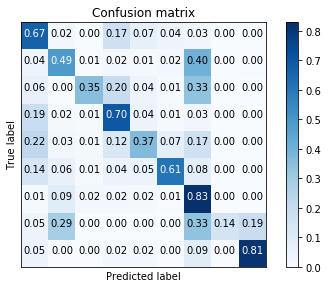

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_30_load_all.d2v
Use test model: docEmbeddings_30_load_all.d2v
begin training

Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 2s 497us/step - loss: 2.0019 - acc: 0.2450 - val_loss: 1.4991 - val_acc: 0.4706
Epoch 2/2
3281/3281 [==============================] - 0s 63us/step - loss: 1.6203 - acc: 0.4127 - val_loss: 1.2994 - val_acc: 0.5882
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 64us/step - loss: 1.4277 - acc: 0.4700 - val_loss: 1.2229 - val_acc: 0.5588
Epoch 2/2
3281/3281 [==============================] - 0s 64us/step - loss: 1.3361 - acc: 0.5136 - val_loss: 1.0941 - val_acc: 0.5588
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 64us/step - loss: 1.2702 - acc: 0.5398 - val_loss: 1.0163 - val_acc: 0.6471
Epoch 2/2
3281/3281 [======================

3281/3281 [==============================] - 0s 64us/step - loss: 0.6377 - acc: 0.7543 - val_loss: 0.8672 - val_acc: 0.7353
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 63us/step - loss: 0.6300 - acc: 0.7571 - val_loss: 0.8653 - val_acc: 0.7353
Epoch 2/2
3281/3281 [==============================] - 0s 64us/step - loss: 0.6225 - acc: 0.7665 - val_loss: 0.8739 - val_acc: 0.7353
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 63us/step - loss: 0.6304 - acc: 0.7598 - val_loss: 0.8622 - val_acc: 0.7059
Epoch 2/2
3281/3281 [==============================] - 0s 63us/step - loss: 0.6037 - acc: 0.7693 - val_loss: 0.8659 - val_acc: 0.7353
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 63us/step - loss: 0.6109 - acc: 0.7614 - val_loss: 0.9102 - val_acc: 0.7353
Epoch 2/2
3281/3281 [==============================] - 0s 62us/step 

3283/3283 [==============================] - 0s 73us/step - loss: 0.6937 - acc: 0.7417 - val_loss: 0.8810 - val_acc: 0.7059
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 72us/step - loss: 0.6757 - acc: 0.7514 - val_loss: 0.9048 - val_acc: 0.6765
Epoch 2/2
3283/3283 [==============================] - 0s 70us/step - loss: 0.6794 - acc: 0.7341 - val_loss: 0.8980 - val_acc: 0.6765
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 71us/step - loss: 0.6587 - acc: 0.7457 - val_loss: 0.9153 - val_acc: 0.7059
Epoch 2/2
3283/3283 [==============================] - 0s 70us/step - loss: 0.6673 - acc: 0.7475 - val_loss: 0.8859 - val_acc: 0.7059
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 74us/step - loss: 0.6444 - acc: 0.7588 - val_loss: 0.9357 - val_acc: 0.7059
Epoch 2/2
3283/3283 [==============================] - 0s 72us/step 

3284/3284 [==============================] - 0s 63us/step - loss: 0.7638 - acc: 0.7046 - val_loss: 0.9546 - val_acc: 0.6176
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 64us/step - loss: 0.7519 - acc: 0.7183 - val_loss: 0.9662 - val_acc: 0.6176
Epoch 2/2
3284/3284 [==============================] - 0s 64us/step - loss: 0.7480 - acc: 0.7211 - val_loss: 0.9609 - val_acc: 0.5882
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 64us/step - loss: 0.7471 - acc: 0.7177 - val_loss: 0.9808 - val_acc: 0.6471
Epoch 2/2
3284/3284 [==============================] - 0s 64us/step - loss: 0.7307 - acc: 0.7141 - val_loss: 0.9447 - val_acc: 0.6765
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 66us/step - loss: 0.7258 - acc: 0.7232 - val_loss: 0.9911 - val_acc: 0.5882
Epoch 2/2
3284/3284 [==============================] - 0s 64us/step 

3285/3285 [==============================] - 0s 74us/step - loss: 0.8177 - acc: 0.6904 - val_loss: 0.7707 - val_acc: 0.6765
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 70us/step - loss: 0.8156 - acc: 0.6868 - val_loss: 0.7728 - val_acc: 0.6471
Epoch 2/2
3285/3285 [==============================] - 0s 66us/step - loss: 0.8069 - acc: 0.6953 - val_loss: 0.7841 - val_acc: 0.6765
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 65us/step - loss: 0.7861 - acc: 0.7023 - val_loss: 0.7852 - val_acc: 0.6471
Epoch 2/2
3285/3285 [==============================] - 0s 72us/step - loss: 0.7972 - acc: 0.6998 - val_loss: 0.7927 - val_acc: 0.6471
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 72us/step - loss: 0.7858 - acc: 0.7065 - val_loss: 0.7955 - val_acc: 0.6176
Epoch 2/2
3285/3285 [==============================] - 0s 68us/step 

3286/3286 [==============================] - 0s 65us/step - loss: 0.9133 - acc: 0.6625 - val_loss: 0.7579 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 65us/step - loss: 0.9060 - acc: 0.6646 - val_loss: 0.7606 - val_acc: 0.7059
Epoch 2/2
3286/3286 [==============================] - 0s 64us/step - loss: 0.8902 - acc: 0.6765 - val_loss: 0.7968 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 65us/step - loss: 0.8830 - acc: 0.6692 - val_loss: 0.7925 - val_acc: 0.7353
Epoch 2/2
3286/3286 [==============================] - 0s 64us/step - loss: 0.8683 - acc: 0.6713 - val_loss: 0.7600 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 65us/step - loss: 0.8536 - acc: 0.6808 - val_loss: 0.7470 - val_acc: 0.7353
Epoch 2/2
3286/3286 [==============================] - 0s 64us/step 

3286/3286 [==============================] - 0s 65us/step - loss: 1.0717 - acc: 0.6068 - val_loss: 0.9595 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 65us/step - loss: 1.0494 - acc: 0.6166 - val_loss: 0.9289 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 64us/step - loss: 1.0394 - acc: 0.6263 - val_loss: 0.8889 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 65us/step - loss: 1.0191 - acc: 0.6248 - val_loss: 0.9109 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 64us/step - loss: 0.9913 - acc: 0.6360 - val_loss: 0.9031 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 64us/step - loss: 0.9784 - acc: 0.6382 - val_loss: 0.9255 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 64us/step 

3287/3287 [==============================] - 0s 67us/step - loss: 1.3560 - acc: 0.5068 - val_loss: 1.0608 - val_acc: 0.6471
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 64us/step - loss: 1.2819 - acc: 0.5376 - val_loss: 0.9739 - val_acc: 0.6765
Epoch 2/2
3287/3287 [==============================] - 0s 66us/step - loss: 1.2155 - acc: 0.5643 - val_loss: 0.9102 - val_acc: 0.7059
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 73us/step - loss: 1.1707 - acc: 0.5729 - val_loss: 0.8713 - val_acc: 0.7059
Epoch 2/2
3287/3287 [==============================] - 0s 66us/step - loss: 1.1386 - acc: 0.5902 - val_loss: 0.8737 - val_acc: 0.7059
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 65us/step - loss: 1.1004 - acc: 0.5896 - val_loss: 0.8583 - val_acc: 0.6471
Epoch 2/2
3287/3287 [==============================] - 0s 70us/step 

3287/3287 [==============================] - 0s 65us/step - loss: 0.5971 - acc: 0.7648 - val_loss: 0.7611 - val_acc: 0.7059
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 64us/step - loss: 0.5956 - acc: 0.7651 - val_loss: 0.8141 - val_acc: 0.7059
Epoch 2/2
3287/3287 [==============================] - 0s 65us/step - loss: 0.5831 - acc: 0.7651 - val_loss: 0.7743 - val_acc: 0.6765
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 64us/step - loss: 0.5925 - acc: 0.7740 - val_loss: 0.7607 - val_acc: 0.7353
Epoch 2/2
3287/3287 [==============================] - 0s 65us/step - loss: 0.5763 - acc: 0.7749 - val_loss: 0.7485 - val_acc: 0.7353
begin training

Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 3s 862us/step - loss: 1.8824 - acc: 0.2971 - val_loss: 1.4661 - val_acc: 0.4706
Epoch 2/2
3289/3289 [==============================

3289/3289 [==============================] - 0s 65us/step - loss: 0.6556 - acc: 0.7458 - val_loss: 0.8466 - val_acc: 0.7059
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 64us/step - loss: 0.6476 - acc: 0.7555 - val_loss: 0.8393 - val_acc: 0.6765
Epoch 2/2
3289/3289 [==============================] - 0s 65us/step - loss: 0.6458 - acc: 0.7516 - val_loss: 0.8468 - val_acc: 0.7059
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 65us/step - loss: 0.6491 - acc: 0.7528 - val_loss: 0.8374 - val_acc: 0.6176
Epoch 2/2
3289/3289 [==============================] - 0s 64us/step - loss: 0.6444 - acc: 0.7522 - val_loss: 0.8810 - val_acc: 0.6176
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 65us/step - loss: 0.6290 - acc: 0.7555 - val_loss: 0.8257 - val_acc: 0.7059
Epoch 2/2
3289/3289 [==============================] - 0s 64us/step 

3290/3290 [==============================] - 0s 68us/step - loss: 0.7344 - acc: 0.7213 - val_loss: 0.8582 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 76us/step - loss: 0.7322 - acc: 0.7191 - val_loss: 0.8686 - val_acc: 0.6471
Epoch 2/2
3290/3290 [==============================] - 0s 73us/step - loss: 0.7134 - acc: 0.7286 - val_loss: 0.8622 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 74us/step - loss: 0.7065 - acc: 0.7334 - val_loss: 0.8782 - val_acc: 0.6471
Epoch 2/2
3290/3290 [==============================] - 0s 74us/step - loss: 0.7212 - acc: 0.7304 - val_loss: 0.8732 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 78us/step - loss: 0.7041 - acc: 0.7316 - val_loss: 0.8483 - val_acc: 0.6471
Epoch 2/2
3290/3290 [==============================] - 0s 98us/step 

3290/3290 [==============================] - 0s 73us/step - loss: 0.7822 - acc: 0.7085 - val_loss: 0.8894 - val_acc: 0.6765
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 68us/step - loss: 0.7774 - acc: 0.7070 - val_loss: 0.8631 - val_acc: 0.6765
Epoch 2/2
3290/3290 [==============================] - 0s 74us/step - loss: 0.7734 - acc: 0.7073 - val_loss: 0.8506 - val_acc: 0.7059
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 72us/step - loss: 0.7657 - acc: 0.7125 - val_loss: 0.8491 - val_acc: 0.7059
Epoch 2/2
3290/3290 [==============================] - 0s 69us/step - loss: 0.7481 - acc: 0.7152 - val_loss: 0.8874 - val_acc: 0.6765
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 65us/step - loss: 0.7456 - acc: 0.7155 - val_loss: 0.8352 - val_acc: 0.6765
Epoch 2/2
3290/3290 [==============================] - 0s 65us/step 

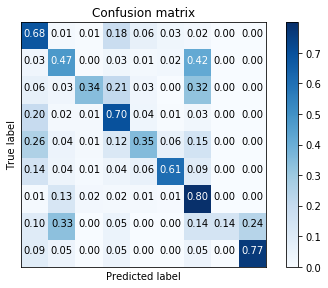

Successfully loaded the textmodel from ../model/doc2vec/textModel_win=30_no_outside
Use test model: textModel_win=30_no_outside
begin training

Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 2s 601us/step - loss: 1.9213 - acc: 0.2636 - val_loss: 1.5893 - val_acc: 0.4706
Epoch 2/2
3281/3281 [==============================] - 0s 66us/step - loss: 1.7712 - acc: 0.3475 - val_loss: 1.4498 - val_acc: 0.4706
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 66us/step - loss: 1.6736 - acc: 0.3926 - val_loss: 1.3281 - val_acc: 0.5294
Epoch 2/2
3281/3281 [==============================] - 0s 67us/step - loss: 1.5727 - acc: 0.4258 - val_loss: 1.2587 - val_acc: 0.5294
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 73us/step - loss: 1.5051 - acc: 0.4489 - val_loss: 1.2035 - val_acc: 0.5294
Epoch 2/2
3281/3281 [==========================

3281/3281 [==============================] - 0s 66us/step - loss: 0.6072 - acc: 0.7699 - val_loss: 0.6985 - val_acc: 0.7941
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 69us/step - loss: 0.6175 - acc: 0.7681 - val_loss: 0.7308 - val_acc: 0.7353
Epoch 2/2
3281/3281 [==============================] - 0s 67us/step - loss: 0.5821 - acc: 0.7857 - val_loss: 0.7130 - val_acc: 0.7059
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 68us/step - loss: 0.5837 - acc: 0.7830 - val_loss: 0.7155 - val_acc: 0.7941
Epoch 2/2
3281/3281 [==============================] - 0s 66us/step - loss: 0.5808 - acc: 0.7839 - val_loss: 0.7054 - val_acc: 0.7353
Train on 3281 samples, validate on 34 samples
Epoch 1/2
3281/3281 [==============================] - 0s 67us/step - loss: 0.5656 - acc: 0.7906 - val_loss: 0.7179 - val_acc: 0.7059
Epoch 2/2
3281/3281 [==============================] - 0s 66us/step 

3283/3283 [==============================] - 0s 69us/step - loss: 0.6927 - acc: 0.7478 - val_loss: 0.7194 - val_acc: 0.7353
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 74us/step - loss: 0.6880 - acc: 0.7554 - val_loss: 0.7114 - val_acc: 0.7059
Epoch 2/2
3283/3283 [==============================] - 0s 68us/step - loss: 0.6642 - acc: 0.7597 - val_loss: 0.6702 - val_acc: 0.7353
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 71us/step - loss: 0.6655 - acc: 0.7566 - val_loss: 0.7458 - val_acc: 0.6765
Epoch 2/2
3283/3283 [==============================] - 0s 70us/step - loss: 0.6519 - acc: 0.7621 - val_loss: 0.7645 - val_acc: 0.7059
Train on 3283 samples, validate on 34 samples
Epoch 1/2
3283/3283 [==============================] - 0s 67us/step - loss: 0.6418 - acc: 0.7667 - val_loss: 0.7189 - val_acc: 0.7059
Epoch 2/2
3283/3283 [==============================] - 0s 66us/step 

3284/3284 [==============================] - 0s 68us/step - loss: 0.8024 - acc: 0.7116 - val_loss: 0.8007 - val_acc: 0.6765
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 79us/step - loss: 0.7783 - acc: 0.7189 - val_loss: 0.8231 - val_acc: 0.7353
Epoch 2/2
3284/3284 [==============================] - 0s 72us/step - loss: 0.7719 - acc: 0.7168 - val_loss: 0.7969 - val_acc: 0.7353
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 72us/step - loss: 0.7517 - acc: 0.7202 - val_loss: 0.8328 - val_acc: 0.7353
Epoch 2/2
3284/3284 [==============================] - 0s 71us/step - loss: 0.7630 - acc: 0.7238 - val_loss: 0.8024 - val_acc: 0.7059
Train on 3284 samples, validate on 34 samples
Epoch 1/2
3284/3284 [==============================] - 0s 68us/step - loss: 0.7361 - acc: 0.7326 - val_loss: 0.7898 - val_acc: 0.7059
Epoch 2/2
3284/3284 [==============================] - 0s 68us/step 

3285/3285 [==============================] - 0s 69us/step - loss: 0.9160 - acc: 0.6721 - val_loss: 0.7333 - val_acc: 0.7059
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 69us/step - loss: 0.8953 - acc: 0.6852 - val_loss: 0.7447 - val_acc: 0.7353
Epoch 2/2
3285/3285 [==============================] - 0s 68us/step - loss: 0.8949 - acc: 0.6816 - val_loss: 0.7204 - val_acc: 0.7353
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 68us/step - loss: 0.8552 - acc: 0.6913 - val_loss: 0.7005 - val_acc: 0.7059
Epoch 2/2
3285/3285 [==============================] - 0s 72us/step - loss: 0.8419 - acc: 0.7038 - val_loss: 0.7057 - val_acc: 0.7647
Train on 3285 samples, validate on 34 samples
Epoch 1/2
3285/3285 [==============================] - 0s 71us/step - loss: 0.8332 - acc: 0.7105 - val_loss: 0.7026 - val_acc: 0.7353
Epoch 2/2
3285/3285 [==============================] - 0s 68us/step 

3286/3286 [==============================] - 0s 76us/step - loss: 1.0324 - acc: 0.6312 - val_loss: 0.7829 - val_acc: 0.7353
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 82us/step - loss: 1.0157 - acc: 0.6409 - val_loss: 0.7598 - val_acc: 0.7353
Epoch 2/2
3286/3286 [==============================] - 0s 107us/step - loss: 0.9931 - acc: 0.6461 - val_loss: 0.6960 - val_acc: 0.7353
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 106us/step - loss: 0.9751 - acc: 0.6506 - val_loss: 0.7126 - val_acc: 0.7353
Epoch 2/2
3286/3286 [==============================] - 0s 81us/step - loss: 0.9567 - acc: 0.6561 - val_loss: 0.7525 - val_acc: 0.7647
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 71us/step - loss: 0.9464 - acc: 0.6649 - val_loss: 0.7283 - val_acc: 0.7941
Epoch 2/2
3286/3286 [==============================] - 0s 71us/ste

3286/3286 [==============================] - 0s 97us/step - loss: 1.2075 - acc: 0.5560 - val_loss: 0.8173 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 69us/step - loss: 1.1719 - acc: 0.5822 - val_loss: 0.8065 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 74us/step - loss: 1.1550 - acc: 0.5794 - val_loss: 0.7748 - val_acc: 0.6765
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 70us/step - loss: 1.1032 - acc: 0.5986 - val_loss: 0.7628 - val_acc: 0.6765
Epoch 2/2
3286/3286 [==============================] - 0s 71us/step - loss: 1.1102 - acc: 0.6074 - val_loss: 0.7581 - val_acc: 0.7059
Train on 3286 samples, validate on 34 samples
Epoch 1/2
3286/3286 [==============================] - 0s 83us/step - loss: 1.0575 - acc: 0.6223 - val_loss: 0.7277 - val_acc: 0.7059
Epoch 2/2
3286/3286 [==============================] - 0s 73us/step 

3287/3287 [==============================] - 0s 70us/step - loss: 1.5460 - acc: 0.4378 - val_loss: 1.2648 - val_acc: 0.5294
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 71us/step - loss: 1.5023 - acc: 0.4460 - val_loss: 1.2143 - val_acc: 0.5588
Epoch 2/2
3287/3287 [==============================] - 0s 71us/step - loss: 1.4491 - acc: 0.4734 - val_loss: 1.1967 - val_acc: 0.6176
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 68us/step - loss: 1.3939 - acc: 0.4880 - val_loss: 1.1187 - val_acc: 0.6471
Epoch 2/2
3287/3287 [==============================] - 0s 91us/step - loss: 1.3741 - acc: 0.4965 - val_loss: 1.0653 - val_acc: 0.6471
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 75us/step - loss: 1.3332 - acc: 0.5075 - val_loss: 1.0167 - val_acc: 0.6176
Epoch 2/2
3287/3287 [==============================] - 0s 78us/step 

3287/3287 [==============================] - 0s 69us/step - loss: 0.5818 - acc: 0.7864 - val_loss: 0.8590 - val_acc: 0.7059
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 67us/step - loss: 0.5603 - acc: 0.7892 - val_loss: 0.8571 - val_acc: 0.7353
Epoch 2/2
3287/3287 [==============================] - 0s 67us/step - loss: 0.5712 - acc: 0.7959 - val_loss: 0.8403 - val_acc: 0.7647
Train on 3287 samples, validate on 34 samples
Epoch 1/2
3287/3287 [==============================] - 0s 69us/step - loss: 0.5583 - acc: 0.7965 - val_loss: 0.8313 - val_acc: 0.7059
Epoch 2/2
3287/3287 [==============================] - 0s 67us/step - loss: 0.5410 - acc: 0.8010 - val_loss: 0.8404 - val_acc: 0.7353
begin training

Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 2s 681us/step - loss: 1.9716 - acc: 0.2475 - val_loss: 1.5614 - val_acc: 0.4706
Epoch 2/2
3289/3289 [==============================

3289/3289 [==============================] - 0s 75us/step - loss: 0.6465 - acc: 0.7598 - val_loss: 0.7222 - val_acc: 0.6765
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 70us/step - loss: 0.6361 - acc: 0.7732 - val_loss: 0.6821 - val_acc: 0.6765
Epoch 2/2
3289/3289 [==============================] - 0s 70us/step - loss: 0.6184 - acc: 0.7738 - val_loss: 0.6548 - val_acc: 0.6765
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 74us/step - loss: 0.6042 - acc: 0.7805 - val_loss: 0.6566 - val_acc: 0.6765
Epoch 2/2
3289/3289 [==============================] - 0s 78us/step - loss: 0.6110 - acc: 0.7738 - val_loss: 0.6286 - val_acc: 0.7059
Train on 3289 samples, validate on 34 samples
Epoch 1/2
3289/3289 [==============================] - 0s 78us/step - loss: 0.6098 - acc: 0.7750 - val_loss: 0.6618 - val_acc: 0.6471
Epoch 2/2
3289/3289 [==============================] - 0s 71us/step 

3290/3290 [==============================] - 0s 73us/step - loss: 0.7233 - acc: 0.7435 - val_loss: 0.7140 - val_acc: 0.6176
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 74us/step - loss: 0.7156 - acc: 0.7422 - val_loss: 0.7025 - val_acc: 0.6765
Epoch 2/2
3290/3290 [==============================] - 0s 73us/step - loss: 0.7077 - acc: 0.7407 - val_loss: 0.7076 - val_acc: 0.6765
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 73us/step - loss: 0.7058 - acc: 0.7422 - val_loss: 0.6951 - val_acc: 0.6176
Epoch 2/2
3290/3290 [==============================] - 0s 70us/step - loss: 0.6762 - acc: 0.7541 - val_loss: 0.7281 - val_acc: 0.6471
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 80us/step - loss: 0.6648 - acc: 0.7520 - val_loss: 0.6847 - val_acc: 0.6471
Epoch 2/2
3290/3290 [==============================] - 0s 76us/step 

3290/3290 [==============================] - 0s 77us/step - loss: 0.8375 - acc: 0.6933 - val_loss: 0.7076 - val_acc: 0.7059
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 78us/step - loss: 0.8225 - acc: 0.7009 - val_loss: 0.6782 - val_acc: 0.6765
Epoch 2/2
3290/3290 [==============================] - 0s 78us/step - loss: 0.8067 - acc: 0.7131 - val_loss: 0.6744 - val_acc: 0.7647
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 78us/step - loss: 0.7992 - acc: 0.7094 - val_loss: 0.7167 - val_acc: 0.6765
Epoch 2/2
3290/3290 [==============================] - 0s 80us/step - loss: 0.7909 - acc: 0.7073 - val_loss: 0.6871 - val_acc: 0.6765
Train on 3290 samples, validate on 34 samples
Epoch 1/2
3290/3290 [==============================] - 0s 78us/step - loss: 0.7533 - acc: 0.7331 - val_loss: 0.7348 - val_acc: 0.6471
Epoch 2/2
3290/3290 [==============================] - 0s 77us/step 

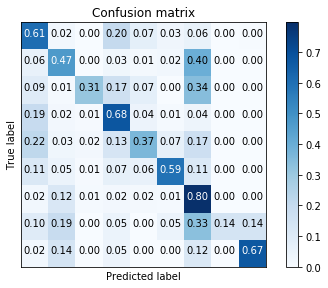

In [68]:
for model in modelName:
    text_model = wel.loadTextModel(PATH + model)
    text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)
    train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
    test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
    X_train = np.array(train_set)
    X_test = np.array(test_set)
    print("Use test model: " + model)
    nn_cross_validation(X_train, y, encoded_y)
    


In [56]:
y_pred_proba = NN_model.predict_proba(X_test)

In [57]:
y_pred = np.argmax(y_predict, axis = 1)

In [62]:
print(type(y_pred))
print(y_pred_proba[:10])

<class 'numpy.ndarray'>
[[  6.42123878e-01   5.68419462e-03   1.20462831e-02   1.99772403e-01
    9.59234685e-02   3.07848640e-02   1.22579243e-02   9.33274277e-04
    4.73716063e-04]
 [  6.08799160e-01   1.06558669e-03   1.64968206e-03   3.72251213e-01
    5.34702698e-03   8.07844941e-03   1.82031468e-03   6.98966149e-04
    2.89670046e-04]
 [  6.00796053e-03   8.34848583e-02   1.99606200e-03   3.64352087e-03
    1.85364590e-03   8.96764628e-04   8.98898959e-01   2.72210105e-03
    4.96144639e-04]
 [  2.06863612e-01   3.05877507e-01   1.77739968e-03   7.73829818e-02
    6.20944658e-03   8.73012375e-03   3.59056264e-01   2.36274302e-02
    1.04752388e-02]
 [  3.32952011e-03   1.46441370e-01   7.98771251e-03   6.49681687e-03
    1.07387956e-02   2.05379468e-03   8.17908585e-01   3.78938811e-03
    1.25404028e-03]
 [  8.63160849e-01   4.18370180e-02   2.00103023e-04   3.03073525e-02
    4.05042898e-03   1.09452149e-02   4.10042815e-02   6.02450036e-03
    2.47023441e-03]
 [  2.64032464e-